Program Name: Jet_Length_Width_Determiner_v3.py

Date: 6/14/2022

Creator: Sol Samuels

Description: 
 - This program intakes jet related FITS files from ones device, specifically those named in the format \*\*/Group\*0.00_1.00_0.00\*.fits\* , and returns the jet's estimated length and width.
 - The program returns a table for each frequency and its information of year vs. jet dimension
 - NOTE: This is version 3, first DRAFT of this program. Program is subject to be changed.
 
Variable Keywords:
 - cul = "cumulative"
 - slice = refers to rows or columns of fits image pixels
 - vals = "values"
 - norm = "normalized"

In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import time

from astropy.io import fits

In [2]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    return jet_size_kpc
    


In [3]:
#This Function Takes FITS data, FITS image width and pixel size to display Jet Width Info
def jet_width(data, width, pixel_size):
    
    #Reorients data so rows become columns
    data_reorient = []
    for x in range(width):
        col_sub = []
        for row in data:
            col_sub.append(row[x])
        data_reorient.append(col_sub)
        
    #Creates list of slice sums
    slice_vals = []
    for row in data_reorient:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    return jet_size_kpc
   

In [4]:
def progress(file_count, total_files):
    print("\tFiles Completed: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)

In [5]:
#Main Calling Block of Code

print("\nJET LENGTH AND WIDTH DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

nu = [30.0, 74.0, 150.0, 315.0, 395.0, 460.0, 630.0, 730.0, 1400.0, 3000.0, 5000.0, 8000.0]
nu_count = 0

for value in nu: 
    path = '**/Group*nu='+str(value)+'*0.00_1.00_0.00*.fits*'
    nu_count += 1

    # Determines if there are any files in device
    total_files = len(glob.glob(path, recursive=True))

    if total_files > 0:
        
        print("\nTRYING NU VALUE {} MHz...".format(str(value)))
        file_count = 0
        progress(file_count, total_files)
        jet_dim_data = np.array([["Time (Myr)", "Jet Length (kpc)", "Jet Width (kpc)"]])

        for file in sorted(glob.glob(path, recursive=True)):

            file_count += 1

            try:
                fits_image_hdul = fits.open(file)

                #Displays FITS Image title, time index, and pixel size
                sim_title = fits_image_hdul[0].header['OBJECT']
                nu_value = int(sim_title[-7:-4])
                sim_time = fits_image_hdul[0].header['TIME']
                sim_time = round(float(sim_time[:-4]), 1)
                pixel = fits_image_hdul[0].header['CDELT1']
                pixel_size = float(pixel[:-3])

                #Difines Data From FITS image and records image dimensions
                data =  fits_image_hdul[0].data
                length = len(data[0])
                width = len(data)

                #Calls jet_length function
                jet_len = jet_length(data, pixel_size)

                #Calls jet_width function
                jet_wid = jet_width(data, width, pixel_size)


                file_data = np.array([float(sim_time), jet_len, jet_wid])
                jet_dim_data = np.vstack([jet_dim_data, file_data])
                
                progress(file_count, total_files)

            except OSError:
                print("Error with file: {}".format(file))
                print("Empty or corrupt FITS file")

        print("\n\n TABLE OF JET LENGTHS AND WIDTHS OVER TIME FOR NU={} MHz:".format(str(value)))
        data_table = pd.DataFrame(jet_dim_data)
        
        
        print(data_table)
        with open("data_table_{}MHz.npy".format(str(value)), "wb") as open_file:
            np.save(open_file, jet_dim_data)
        


JET LENGTH AND WIDTH DETERMINING PROGRAM:
____________________________________________________________________________________________________


TRYING NU VALUE 30.0 MHz...
	Files Completed: 11/11

 TABLE OF JET LENGTHS AND WIDTHS OVER TIME FOR NU=30.0 MHz:
             0                 1                2
0   Time (Myr)  Jet Length (kpc)  Jet Width (kpc)
1          1.0           10.9376           4.4561
2          2.0           18.6345           6.0765
3          4.0           30.7874           8.9121
4          8.0           49.0168          13.7733
5         16.0           80.6144          21.8753
6         32.0          122.3394          34.4333
7         64.0          189.9907          61.5748
8        121.2          350.0042         110.9967
9        256.1           698.793         182.6989
10       513.1          964.1318         222.8036
11       773.1          905.7978         221.5883

TRYING NU VALUE 74.0 MHz...
	Files Completed: 11/11

 TABLE OF JET LENGTHS AND WIDTHS OVER

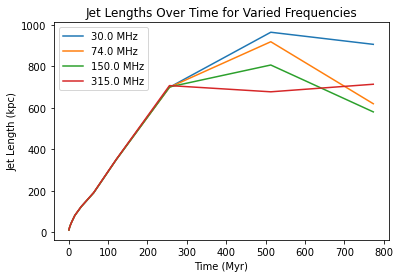

In [6]:
for value in nu:
    try:
        with open("data_table_{}MHz.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_len_vals = []

            for i in range(1, 12):
                time_vals.append(float(current_freq[i, 0]))
                jet_len_vals.append(float(current_freq[i, 1]))
            
            plt.plot(time_vals, jet_len_vals, label="{} MHz".format(str(value)))
        
    except:
        p = 0
        
plt.xlabel("Time (Myr)")
plt.ylabel("Jet Length (kpc)")
plt.title("Jet Lengths Over Time for Varied Frequencies")
plt.legend()
plt.show()

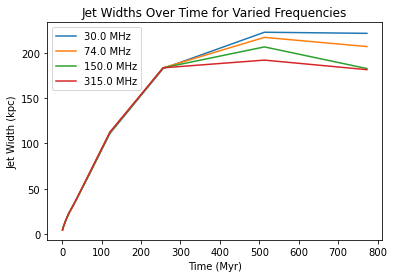

In [7]:
for value in nu:
    try:
        with open("data_table_{}MHz.npy".format(str(value)), "rb") as open_file:
            current_freq = np.load(open_file)
            
            time_vals = []
            jet_wid_vals = []

            for i in range(1, 12):
                time_vals.append(float(current_freq[i, 0]))
                jet_wid_vals.append(float(current_freq[i, 2]))
            
            plt.plot(time_vals, jet_wid_vals, label="{} MHz".format(str(value)))
        
    except:
        p = 0
        
plt.xlabel("Time (Myr)")
plt.ylabel("Jet Width (kpc)")
plt.title("Jet Widths Over Time for Varied Frequencies")
plt.legend()
plt.show()